# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные находятся [здесь](https://st.yandex-team.ru/DS-6856).

В файле `train_dataset.csv` собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

# Сборный проект - 4

Задача - разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## 1. Исследовательский анализ данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки(от 1 до 4) от трёх специалистов.
В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.


### 1.1 Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import torchvision.models as models
import os, os.path
import numpy as np
import torch
import transformers 
import torch.nn as nn

from tqdm import notebook
from tqdm import tqdm
from torchvision import transforms
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from PIL import Image
from wordfilter import Wordfilter
from warnings import simplefilter
import ntpath
import time

simplefilter(action='ignore', category=FutureWarning)

Загрузим данные и прочитаем датасеты:

In [2]:
train_dataset = pd.read_csv('C:/Users/Jepka/Documents/projects/yandex-practicum-DS-plus/17_sborn_proj_4/train_dataset.csv')
train_dataset.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [3]:
test_queries = pd.read_csv('C:/Users/Jepka/Documents/projects/yandex-practicum-DS-plus/17_sborn_proj_4/test_queries.csv', sep='|', index_col=0)
test_queries.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


Таблица с краудсорсинговыми оценками:

In [4]:
crowd_ann = pd.read_csv('C:/Users/Jepka/Documents/projects/yandex-practicum-DS-plus/17_sborn_proj_4/CrowdAnnotations.tsv', sep="\t")
display(crowd_ann.head(5))
print(crowd_ann.info())

,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1,3,0
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   1056338697_4f7d7ce270.jpg    47829 non-null  object 
 1   1056338697_4f7d7ce270.jpg#2  47829 non-null  object 
 2   1                            47829 non-null  float64
 3   3                            47829 non-null  int64  
 4   0                            47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None


Таблица с экспертными оценками:

In [5]:
exp_ann = pd.read_csv('C:/Users/Jepka/Documents/projects/yandex-practicum-DS-plus/17_sborn_proj_4/ExpertAnnotations.tsv', sep="\t")
display(exp_ann.head(5))
print(exp_ann.info())

,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1.1,1.2
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   1056338697_4f7d7ce270.jpg    5821 non-null   object
 1   2549968784_39bfbe44f9.jpg#2  5821 non-null   object
 2   1                            5821 non-null   int64 
 3   1.1                          5821 non-null   int64 
 4   1.2                          5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB
None


Таблица с оценками экспертов содержит столько же строк, как и обучающий датасет, то есть оценки проводились на этом датасете. В краудсорсинговом - ~ 47 тыс строк.

Выделим итоговую оценку из каждого оценочного датасета:

In [6]:
crowd_ann['mark'] = crowd_ann['1'].apply(lambda x: 1 if x > 0.5 else 0) # итоговая оценка положительная, если за 
crowd_ann = crowd_ann.drop((['1', '3', '0']), axis=1)                   # соответсвие проголосовало большинство
crowd_ann.columns = ['image', 'query_id', 'mark']
crowd_ann.sample(5)

,image,query_id,mark
32922,3406930103_4db7b4dde0.jpg,2103568100_5d018c495b.jpg#2,0
44810,509778093_21236bb64d.jpg,3384314832_dffc944152.jpg#2,0
16032,2654514044_a70a6e2c21.jpg,2496370758_a3fbc49837.jpg#2,0
8640,2271755053_e1b1ec8442.jpg,3477715432_79d82487bb.jpg#2,0
38252,3589367895_5d3729e3ea.jpg,424779662_568f9606d0.jpg#2,0


In [7]:
exp_ann['avg'] = (exp_ann['1'] + exp_ann['1.1'] + exp_ann['1.2']) / 3     # считаем среднюю оценку
exp_ann['mark'] = exp_ann['avg'].apply(lambda x: 1 if x >= 3 else 0)      # итоговая оценка положительная, если средняя 
exp_ann = exp_ann.drop((['1', '1.1', '1.2', 'avg']), axis=1)              # оценка > 3
exp_ann.columns = ['image', 'query_id', 'mark']
exp_ann.sample(5)

,image,query_id,mark
3210,3168123064_d1983b8f92.jpg,3255482333_5bcee79f7e.jpg#2,0
1871,2612488996_9450de0e54.jpg,2216695423_1362cb25f3.jpg#2,0
2819,3042380610_c5ea61eef8.jpg,3605061440_1d08c80a57.jpg#2,0
4513,354642192_3b7666a2dd.jpg,2543589122_ec3e55f434.jpg#2,0
2356,2869491449_1041485a6b.jpg,670609997_5c7fdb3f0b.jpg#2,0


Теперь склеим имя файла и id запроса в одну строку, чтобы соединить датасеты по парам:

In [8]:
crowd_ann['pair'] = crowd_ann['image'] + crowd_ann['query_id']
exp_ann['pair'] = exp_ann['image'] + exp_ann['query_id']
train_dataset['pair'] = train_dataset['image'] + train_dataset['query_id']

Попробуем объединить датасеты по столбцу с именем пары. id запроса можно убрать, тк он не несет смысловой нагрузки.

In [9]:
df = train_dataset.merge(crowd_ann, on='pair', suffixes=('', '_y'), how='inner')
df = df.drop((['pair', 'image_y',  'query_id_y', 'query_id']), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       2329 non-null   object
 1   query_text  2329 non-null   object
 2   mark        2329 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 72.8+ KB


In [10]:
df = train_dataset.merge(exp_ann, on='pair', suffixes=('', '_y'), how='inner')
df = df.drop((['pair', 'image_y',  'query_id_y', 'query_id']), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5821 entries, 0 to 5820
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5821 non-null   object
 1   query_text  5821 non-null   object
 2   mark        5821 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 181.9+ KB


После соединения таблиц можно увидеть, что краудсорсинговые оценки соответвуют только 2329 строкам от исходных 5821.
Поэтому для обучения будет использоваться датасет с экспертными оценками, как более соответствующий.

In [11]:
df.head()

,image,query_text,mark
0,1262583859_653f1469a9.jpg,A young child is wearing blue goggles and sitt...,0
1,2447284966_d6bbdb4b6e.jpg,A young child is wearing blue goggles and sitt...,0
2,2549968784_39bfbe44f9.jpg,A young child is wearing blue goggles and sitt...,1
3,2621415349_ef1a7e73be.jpg,A young child is wearing blue goggles and sitt...,0
4,3030566410_393c36a6c5.jpg,A young child is wearing blue goggles and sitt...,0


0    0.892974
1    0.107026
Name: mark, dtype: float64


<AxesSubplot:>

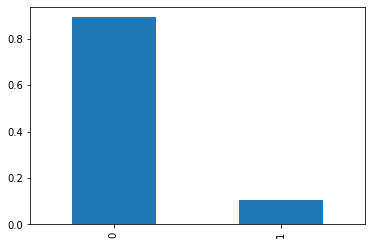

In [12]:
class_frequency = df['mark'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar') 

В получившемся датасете остается столбец с именем файла, текстом запроса и оценкой соответствия запросу. 

Из гистограммы можем увидеть, что изображение соответсвует запросу в 10% случаев.

## 2. Проверка данных

В некоторых странах действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

 Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Составим список слов, которые не соответствуют юридическим ограничениям:

In [13]:
bad_query = ['child', 'kid', 'little kid', 
             'little girl', 'little boy', 'boy', 
             'girl' 'baby', 'babies' 'toddler', 'small girl', 
             'young girl' ]

Уберем запросы, которые соответвуют описаниям, содержащим слова из списка:

In [14]:
for query in bad_query:
    df['dlt'] = df['query_text'].apply(lambda x: 1 if query in x else 0) # вспомогательный столбец, 1 если в строке есть слово
    df = df.query('dlt == 0')                                            # берем срез по оставшимся строкам
df = df.drop('dlt', axis=1).reset_index(drop= True)                      # удаляем вспомогательный столбец

## 3. Векторизация изображений

Загрузим модель ResNet-18, предобученную на датасете ImageNet. Тк модель уже предобучена, то заморозим веса:

In [15]:
resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)

C:\Users\Jepka\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jepka\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Используем все слои, кроме последних двух (пулинга и полносвязного):

In [16]:
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

Приведем изображения в нужный формат. Для этого изменим размер картинки, вырежем центр:

In [17]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

Составим список из изображений:

In [18]:
imgs = []
image_filename = []
path = "C:/Users/Jepka/Documents/projects/yandex-practicum-DS-plus/17_sborn_proj_4/train_images"
for f in os.listdir(path):
    imgs.append(Image.open(os.path.join(path,f)).convert('RGB'))
    image_filename.append(ntpath.basename(f))    

Получим вектор для каждого изображения и сформируем из векторов датафрейм:

In [19]:
img_tensor_list = []
for img in imgs:
    image_tensor = preprocess(img).unsqueeze(0)
    output_img_tensor = resnet(image_tensor).flatten()
    output_img_tensor = output_img_tensor.detach().numpy()
    img_tensor_list.append(output_img_tensor)

In [20]:
img_vectors = pd.DataFrame(np.array(img_tensor_list))

In [21]:
img_vectors['image'] = image_filename

In [22]:
img_vectors

,0,1,2,3,4,5,6,7,8,9,...,25079,25080,25081,25082,25083,25084,25085,25086,25087,image
0,1.456535,1.462994,0.003790,0.000000,0.000000,0.000000,0.000000,2.000441,2.571756,2.129662,...,1.216898,0.794865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1056338697_4f7d7ce270.jpg
1,0.000000,0.000000,0.200380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.047913,0.000000,0.735143,0.000000,0.000000,0.000000,0.261585,0.463040,0.007105,106490881_5a2dd9b7bd.jpg
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.589236,0.000000,0.000000,0.000000,...,0.000000,0.232032,1.449345,1.452476,0.158529,0.000000,0.000000,0.000000,0.000000,1082379191_ec1e53f996.jpg
3,0.000000,0.000000,0.000000,0.097844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1084040636_97d9633581.jpg
4,1.214453,1.465554,1.459179,0.256403,0.000000,0.000000,0.000000,2.086749,5.339117,6.691867,...,0.526870,0.403378,0.116980,0.086076,0.000000,0.000000,0.000000,0.382267,0.383825,1096395242_fc69f0ae5a.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,929679367_ff8c7df2ee.jpg
996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111503,...,8.123108,5.614841,1.372722,2.176105,1.186735,1.409801,1.830168,2.546668,1.543139,96420612_feb18fc6c6.jpg
997,0.053531,0.336881,0.460614,1.690570,1.150811,0.377166,0.072227,0.649224,0.556834,0.986798,...,0.000000,0.000000,0.719299,0.188954,0.177200,0.000000,0.000000,0.000000,0.000000,968081289_cdba83ce2e.jpg
998,0.000000,0.000000,0.014372,0.628642,0.519769,1.019938,0.658015,0.281683,0.837937,0.603083,...,3.590300,2.399083,0.522461,0.652743,1.201579,1.751973,2.598096,1.851995,1.659839,979383193_0a542a059d.jpg


Получили датафрейм с векторами каждого изображения.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Для получения эмбеддингов используем предобученную модель Bert.

Инициализируем токенизатор и преобразуем текст в номера токенов из словаря:

In [23]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('bert-large-uncased')
#tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.


In [24]:
tokenized = df['query_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

Найдем максимальную длину вектора:

In [25]:
MAX_LEN=0
for i in range(tokenized.shape[0]):
    if len(tokenized[i]) >= MAX_LEN:
        MAX_LEN = len(tokenized[i])
MAX_LEN        

36

In [26]:
padded = np.array([i + [0]*(MAX_LEN - len(i)) for i in tokenized])
attention_mask = np.where(padded != 0, 1, 0) 

In [27]:
bert_model = transformers.BertModel.from_pretrained('bert-large-uncased',  ignore_mismatched_sizes=True)
#bert_model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased', max_position_embeddings=36, ignore_mismatched_sizes=True)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Получаем эмбеддинги для каждого вектора и формируем в один датафрейм:

In [28]:
%%time

batch_size = 100
embeddings = []
for i in notebook.tqdm(range((padded.shape[0] // batch_size)+1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = bert_model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/47 [00:00<?, ?it/s]

CPU times: total: 1h 8min 35s
Wall time: 10min 9s


In [29]:
features = np.concatenate(embeddings)

print(features.shape)

(4630, 1024)


In [30]:
txt_vectors = pd.DataFrame(features)

In [31]:
txt_vectors

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.630078,0.211911,-1.126594,-0.050744,-0.195052,0.454618,0.120905,0.844596,1.223745,0.412088,...,0.853184,-0.184983,-0.018171,-0.142256,0.155663,0.011803,-0.205833,-0.297778,0.845023,0.570320
1,-0.630078,0.211911,-1.126594,-0.050744,-0.195052,0.454618,0.120905,0.844596,1.223745,0.412088,...,0.853184,-0.184983,-0.018171,-0.142256,0.155663,0.011803,-0.205833,-0.297778,0.845023,0.570320
2,-0.630078,0.211911,-1.126594,-0.050744,-0.195052,0.454618,0.120905,0.844596,1.223745,0.412088,...,0.853184,-0.184983,-0.018171,-0.142256,0.155663,0.011803,-0.205833,-0.297778,0.845023,0.570320
3,-0.630078,0.211911,-1.126594,-0.050744,-0.195052,0.454618,0.120905,0.844596,1.223745,0.412088,...,0.853184,-0.184983,-0.018171,-0.142256,0.155663,0.011803,-0.205833,-0.297778,0.845023,0.570320
4,-0.630078,0.211911,-1.126594,-0.050744,-0.195052,0.454618,0.120905,0.844596,1.223745,0.412088,...,0.853184,-0.184983,-0.018171,-0.142256,0.155663,0.011803,-0.205833,-0.297778,0.845023,0.570320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4625,-0.100240,-0.072855,-0.434183,-0.110113,-0.245369,-0.657806,-0.234010,0.182713,0.634999,0.036176,...,0.494733,0.215826,0.169165,0.270166,0.313629,0.025998,0.223498,-0.473992,0.020720,0.274330
4626,-0.350423,0.375053,-0.848512,0.144301,0.141994,0.176701,-0.065102,0.607299,0.930639,0.181541,...,0.019961,-0.033051,-0.292232,0.351066,0.315154,0.153647,-0.019770,-0.491314,-0.012695,0.135057
4627,-0.581737,-0.244437,-1.266929,-0.022641,-0.157392,0.551860,0.277077,0.272831,1.195415,0.226663,...,0.143346,-0.197774,-0.530073,0.773531,0.599674,0.960711,0.069931,-0.575454,0.023520,0.204774
4628,-0.223642,-0.657285,-0.575864,-0.030740,-0.693219,0.440351,-0.438477,0.242802,0.423493,0.015072,...,-0.006099,-0.436061,-0.563592,1.116406,-0.175166,0.267113,0.063440,-0.830005,-0.535819,0.207307


Получили датафрейм с векторами текстов.

## 5. Объединение векторов

Далле объединим датафрейм векторов изображений и векторов текстов с целевой переменной по общему столбцу image:

In [32]:
txt_vectors['image'] = df['image']
img_vectors['image'] = df['image']
txt_vectors['mark'] = df['mark']

In [33]:
final_df = txt_vectors.merge(img_vectors, on='image', suffixes=('', '_'), how='right')
final_df = final_df.dropna()

In [34]:
final_df.shape

(5093, 26114)

Получаем таблицу из 5093 строк и 25858 столбцов.

## 6. Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и валидационную выборки так, что строки с одинаковым значением `image` будут содержаться либо в обучающем, либо в валидационном датасете.

In [35]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=final_df.drop(columns=['mark']), y=final_df['mark'], groups=final_df['image']))
train_df, test_df = final_df.loc[train_indices], final_df.loc[test_indices]

Определим целевой признак:

In [36]:
X_train = train_df.drop(['mark', 'image'], axis=1)
y_train = train_df['mark']

X_test = test_df.drop(['mark', 'image'], axis=1)
y_test = test_df['mark']

### 6.1 Логистическая регрессия

Первой используем логистичесткую регрессию, и тк классы не сбалансированы, поставим class_weight='balanced'.

In [37]:
model_lr = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

Найдем вероятность принадлежности модели к одному из классов, а также среднеквадратичное отклонение:

In [38]:
model_lr.fit(X_train, y_train)
pred_prob = model_lr.predict_proba(X_test) 
pred_prob = pred_prob[:, 1]

rmse_lr = round(accuracy_score(y_test, pred_prob),3)
print('acc:', rmse_lr)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### 6.2 Полносвязная сеть

В качестве второй модели попробуем полноствязную нейронную сеть:

In [ ]:
opt = Adam(learning_rate=3e-5)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=10, input_dim = X_train.shape[1],  activation='relu'))
model.add(keras.layers.Dense(units=2,  input_dim = 10, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])
model.fit(X_train, y_train, epochs=15, verbose=0,
          validation_data=(X_test, y_test))

In [ ]:
pred_prob = model.predict(X_test)
pred_prob =  pred_prob[:, 1] 

In [ ]:
rmse_keras = round(accuracy_score(y_test, pred_prob), 3) 
print('acc:', rmse_keras)

### 6.3 CatBoost

In [ ]:
model_cb = CatBoostClassifier(depth=5, iterations=1000, random_state=42, learning_rate=0.003, verbose=200)

In [ ]:
model_cb.fit(X_train, y_train)
pred_prob = model_cb.predict_proba(X_test) 
pred_prob = pred_prob[:, 1]
rmse_cb = round(accuracy_score(y_test, pred_prob), 3)
print('acc:', rmse_cb)

Объединим результаты в одну таблицу:

In [ ]:
results = pd.DataFrame([
    [rmse_lr],
    [rmse_keras],
    [rmse_cb]], 
    columns=['RMSE'],
    index=['LogisticRegression', 'Keras', 'CatBoost'])
results.sort_values(by='RMSE')

Наименьшее значение имеет модель CatBoost.

## 7. Тестирование модели

Для тестирования лучшей модели напишем функцию, получающую на вход текст запроса и эмбеддинги для всех тестовых изображений из папки `test_images`.

In [ ]:
wordfilter = Wordfilter()             # фильтр для слов, неприемлемых для поиска
wordfilter.clearList()
wordfilter.addWords(bad_query)

Аналогично с обучающим датасетом получаем эмбеддинги для изображений:

In [ ]:
imgs = []
path = "C:/Users/Jepka/Documents/projects/yandex-practicum-DS-plus/17_sborn_proj_4/test_images"
for f in os.listdir(path):
    imgs.append(Image.open(os.path.join(path,f)).convert('RGB'))

In [ ]:
img_tensor_list = []
for img in imgs:
    image_tensor = preprocess(img).unsqueeze(0)
    output_img_tensor = resnet(image_tensor).flatten()
    output_img_tensor = output_img_tensor.detach().numpy()
    img_tensor_list.append(output_img_tensor)

In [ ]:
img_vectors = pd.DataFrame(np.array(img_tensor_list))

Определим функции:

In [ ]:
def prob(emb, df):
    emb = emb.add_suffix('_')
    e = pd.concat([emb, df], axis=1, )
    #proba = model.predict(e, verbose=0) 
    proba = model_cb.predict_proba(e)              # получаем столбец с вероятностями
    proba = proba[:, 1]

    probs = pd.Series(proba).sort_values(ascending=False)[0:3]  # берем 3 лучших 
    indxs = []
    for i in range(len(probs)):
        indxs.append(probs.index[i])
    print(indxs)
    return indxs

In [ ]:
def testing(query_num):
    queries = df['query_text'].sample(query_num)
    img_df = img_vectors
    for query in queries:
        if wordfilter.blacklisted(query) == True:
            print('This image is unavailable in your country in compliance with local laws.')
        else:
            print(query)
            tokenized = tokenizer.encode(query, add_special_tokens=True)
            padded = np.array(tokenized + [0]*(MAX_LEN - len(tokenized)))
            attention_mask = np.where(padded != 0, 1, 0)
            batch = torch.LongTensor(padded)
            attention_mask_batch = torch.LongTensor(attention_mask)            
            
            with torch.no_grad():
                emb = bert_model(batch.unsqueeze(0), attention_mask=attention_mask_batch.unsqueeze(0))         
                emb = emb[0][:,0,:].numpy()
                
            emb = pd.DataFrame(emb).T
            
            emb[1] = emb
            for i in range(1,100):
                emb[i] = emb[i-1]
                
            emb = emb.T
            indxs = prob(emb, img_df)
    for i in indxs:
        display(imgs[i])

In [ ]:
testing(10)

При тестировании модель выводит одни и те же картинки для каждого запроса. Видимо модель научилась искать универсальную картинку.